In [1]:
import torch
import os
import PATH
import copy
import utils
import numpy as np
from tqdm import tqdm
from models import reader
from models.popen import Auto_popen
from sklearn.metrics import r2_score
import ipynb.analysis_for_MTL as A_MTL
from scipy import stats

/ssd/users/wergillius/Project/UTR_VAE


In [2]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
os.getpid()

44231

# RL

In [4]:
POPEN  = Auto_popen(
    '/ssd/users/wergillius/Project/UTR_VAE/log/Backbone/RL_3_data/iter_by_iter/test_iter.ini')
POPEN.kfold_index = None
loader_set = {}
base_path = POPEN.split_like_paper.copy()
for subset in POPEN.cycle_set:
    POPEN.split_like_paper = [path.replace('cycle', subset) for path in base_path]
    loader_set[subset] = reader.get_dataloader(POPEN)

In [5]:
POPEN  = Auto_popen(
    '/ssd/users/wergillius/Project/UTR_VAE/log/Backbone/RL_3_data/iter_by_iter/schedule_relay_lr.ini')
POPEN.kfold_index = None
loader_set = {}
base_path = POPEN.split_like_paper.copy()
for subset in POPEN.cycle_set:
    POPEN.split_like_paper = [path.replace('cycle', subset) for path in base_path]
    loader_set[subset] = reader.get_dataloader(POPEN)

In [4]:
def reload_model(config_file, device, kfold_index):
    config_file = os.path.join("/ssd/users/wergillius/Project/UTR_VAE/", config_file)
    
    POPEN  = Auto_popen(config_file)
    if kfold_index is None:
        check_point = torch.load(POPEN.vae_pth_path, map_location=device)
    else:
        check_point = torch.load(
            POPEN.vae_pth_path.replace('.pth', '_cv%d.pth'%kfold_index),
            map_location=device)
        
    model = check_point['state_dict'].to(device)
    return model

def val_a_epoch(model, dataloader, device):
    y_true_ls = []
    y_pred_ls = []
    
    model.eval()
    with torch.no_grad():
        for X,Y in tqdm(dataloader):
            X = X.float().to(device)
            y_true_ls.append(Y.cpu().numpy())

            y_pred = model(X)
            y_pred_ls.append(y_pred.cpu().numpy())
    
    y_true_f = np.concatenate( y_true_ls).flatten()
    y_pred_f = np.concatenate( y_pred_ls).flatten()
    
    return y_true_f, y_pred_f

def kfold_load_data(config_file, device, kfold_index, expand_MAP=False):
    config_file = os.path.join("/ssd/users/wergillius/Project/UTR_VAE/", config_file)
    
    POPEN = Auto_popen(config_file)
    POPEN.kfold_index = kfold_index
    
    if expand_MAP:
        if ('human' in POPEN.cycle_set) or ('SubHuman' in POPEN.cycle_set):
            POPEN.cycle_set = set(POPEN.cycle_set+['vleng','unmod1'])
    
    loader_set = {}
    base_path = copy.copy(POPEN.split_like_paper)
    base_csv = copy.copy(POPEN.csv_path)
    # for subset in POPEN.cycle_set:
    #     if base_path is not None:
    #         POPEN.split_like_paper = [path.replace('cycle', subset) for path in base_path]
    #     else:
    #         POPEN.csv_path = base_csv.replace('cycle', subset)
    #     loader_set[subset] = reader.get_dataloader(POPEN)
        
    for subset in POPEN.cycle_set:
        if (subset in ['unmod1', 'human', 'vleng', 'SubHuman','SubVleng']):
            datapopen = Auto_popen('/ssd/users/wergillius/Project/UTR_VAE/log/Backbone/RL_3_data/rl_train_val_10fold/schedule_lr.ini')
            datapopen.split_like_paper = [path.replace('cycle', subset) for path in base_path]
            datapopen.kfold_index = kfold_index
            loader_set[subset] = reader.get_dataloader(datapopen)
            
        elif (subset in ['Andrev2015', 'muscle', 'pc3']):
            datapopen = Auto_popen('/ssd/users/wergillius/Project/UTR_VAE/log/Backbone/RL_celline/MDL_pretrain_relax/pretrain_relax.ini')
            datapopen.csv_path = base_csv.replace('cycle', subset)
            datapopen.kfold_index = kfold_index
            loader_set[subset] = reader.get_dataloader(datapopen)
        
    return loader_set

def pipeline_for_RL_3_data(config_file, which_set=1, device='cpu'):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    model = reload_model(config_file, device)
    
    r2_dict = {}
    for cycle in ['unmod1', 'human', 'vleng']:
        model.task = cycle # which works for normal RL_gru
        dataloader = loader_set[cycle][which_set]
        y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
        r2_dict[cycle] = A_MTL.compute_r2(y_true_f,y_pred_f) , r2_score(y_true_f,y_pred_f)
    
    del model
    
    return r2_dict

In [5]:
def pipeline_cell_line(config_file, which_set=2, device='cpu', kfold_index=None, expand_MAP=False):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    loader_set = kfold_load_data(config_file, device, kfold_index, expand_MAP)
    model = reload_model(config_file, device, kfold_index)
    
    r2_dict = {}
    for cycle in list(loader_set.keys()):
        model.task = cycle # which works for normal RL_gru
        
        if expand_MAP:
            # use human tower to predict unmod1 or vleng
            if (cycle in ['vleng', 'unmod1']) and (model.task not in model.tower.keys()):
                model.task = 'human' if 'human'  in model.tower.keys() else 'SubHuman'
                
        dataloader = loader_set[cycle][which_set]
        y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
        r2_dict[cycle] = stats.spearmanr(y_true_f, y_pred_f)[0]
    
    del model
    
    return r2_dict

In [6]:
def singletask_cell_line(config_file, which_set=2, device='cpu', kfold_index=None):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    popen = Auto_popen("/ssd/users/wergillius/Project/UTR_VAE/"+config_file)
    popen.kfold_index = kfold_index
    dataloader = reader.get_dataloader(popen)[which_set]
    model = reload_model(config_file, device, kfold_index)
    
    
    y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
    r2 = stats.spearmanr(y_true_f, y_pred_f)[0]
    
    del model
    
    return r2

# RL_3_data

In [15]:
config ='log/Backbone/RL_3_data/iter_by_iter/test_iter.ini'
pipeline_for_RL_3_data(config, which_set=2, device='cpu')

{'unmod1': 0.9395372917234949,
 'human': 0.8340929563110809,
 'vleng': 0.8683383761000572}

In [16]:
config ='log/Backbone/RL_3_data/iter_by_iter/schedule_lr.ini'
pipeline_for_RL_3_data(config, which_set=2, device='cpu')

100%|██████████| 475/475 [00:07<00:00, 64.48it/s]


{'unmod1': (0.9402972435547656, 0.9399505875528189),
 'human': (0.8412147062963042, 0.8311119661307604),
 'vleng': (0.875915077555889, 0.8705184482284338)}

In [17]:
config ='log/Backbone/RL_3_data/iter_by_iter/schedule_2.ini'
pipeline_for_RL_3_data(config, which_set=2, device='cpu')

100%|██████████| 475/475 [00:07<00:00, 67.65it/s]


{'unmod1': (0.9417246765097932, 0.9410291955920862),
 'human': (0.8470220105503589, 0.8374807375955304),
 'vleng': (0.8737025317321205, 0.8713187173204677)}

In [18]:
config ='log/Backbone/RL_3_data/iter_by_iter/sC_slr.ini'
pipeline_for_RL_3_data(config, which_set=2, device='cpu')

100%|██████████| 475/475 [00:07<00:00, 66.78it/s]


{'unmod1': (0.9424423931045808, 0.9422269321645774),
 'human': (0.8424086914917722, 0.8267781024823528),
 'vleng': (0.8755940621697794, 0.8743212767518564)}

In [19]:
config ='log/Backbone/RL_3_data/iter_by_iter/schedule_relay.ini'
pipeline_for_RL_3_data(config, which_set=2, device='cpu')

100%|██████████| 475/475 [00:07<00:00, 65.02it/s]


{'unmod1': (0.9424944949388946, 0.9421486297385743),
 'human': (0.8480499239197432, 0.840639027085787),
 'vleng': (0.8761967427980685, 0.8748267512922341)}

## minxing task

In [13]:
config ='log/Backbone/RL_gru/mixing_task/schedual_lr.ini'
pipeline_for_RL_3_data(config, which_set=2, device='cpu')

100%|██████████| 475/475 [00:07<00:00, 66.15it/s]


{'unmod1': (0.9364550076099998, 0.932659350892989),
 'human': (0.7919244895651296, 0.7540741882421584),
 'vleng': (0.8711723841488681, 0.8710421533337529)}

In [12]:
config ='log/Backbone/RL_3_data/iter_by_iter/schedule_relay_lr.ini'
pipeline_for_RL_3_data(config, which_set=2, device='cpu')

100%|██████████| 475/475 [00:06<00:00, 68.71it/s]


{'unmod1': (0.9434344998236521, 0.9432230246422705),
 'human': (0.8399794484716809, 0.8324911914304305),
 'vleng': (0.8715860181470801, 0.8694446119352591)}

# Fig 2 A

## RL_gru

In [9]:
def pipeline_for_RL_gru(config_file, which_set=2, device='cpu', kfold_index=None):
    config_file = os.path.join("/ssd/users/wergillius/Project/UTR_VAE/", config_file)
    POPEN = Auto_popen(config_file)
    POPEN.kfold_index = kfold_index
    
    dataloader = reader.get_dataloader(POPEN)[which_set]
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    model = reload_model(config_file, device, kfold_index)
    
    y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
    r2 =  r2_score(y_true_f,y_pred_f)

    del model
    
    return r2

### unmod1_new

In [26]:
umod1_single = []
for i in range(10):
    umod1_single.append(pipeline_for_RL_gru('log/Backbone/RL_gru/ds4rl_unmod1_new/schdule_cv.ini', 2 , 3, i))

100%|██████████| 625/625 [00:03<00:00, 158.53it/s]


### ds4rl_human_reset

In [27]:
human_single = []
for i in range(10):
    human_single.append(pipeline_for_RL_gru('log/Backbone/RL_gru/ds4rl_human_reset/schdule_cv.ini', 2 , 3, i))

100%|██████████| 781/781 [00:04<00:00, 157.77it/s]


### vleng_new

In [28]:
vleng_single = []
for i in range(10):
    vleng_single.append(pipeline_for_RL_gru('log/Backbone/RL_gru/ds4rl_vleng_new/schdule_cv.ini', 2 , 3, i))

100%|██████████| 475/475 [00:03<00:00, 148.38it/s]


## Multi-task

In [7]:
def pipeline_for_kfold(config_file, which_set=1, device='cpu', kfold_index=None):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    
    loader_set = kfold_load_data('log/Backbone/RL_3_data/rl_train_val_10fold/schedule_lr.ini', device, kfold_index)
    model = reload_model(config_file, device, kfold_index)
    
    r2_dict = {}
    for cycle in list(loader_set.keys()):
        model.task = cycle # which works for normal RL_gru
        dataloader = loader_set[cycle][which_set]
        y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
        r2_dict[cycle] = r2_score(y_true_f,y_pred_f)
    
    del model
    
    return r2_dict

In [19]:
MTL_performance = {key:[] for key in ['unmod1', 'human', 'vleng']}

for k in range(10):
    config_file = 'log/Backbone/RL_3_data/rl_train_val_10fold/schedule_lr.ini'
    dictt = pipeline_for_kfold(config_file, which_set=2, device=3, kfold_index=k)
    
    for key,values in MTL_performance.items():
        values.append(dictt[key])

100%|██████████| 475/475 [00:06<00:00, 69.12it/s] 


In [20]:
MTL_performance

{'unmod1': [0.9401898592731381,
  0.9415782267837862,
  0.9419950079513633,
  0.94224749521712,
  0.9432278522994351,
  0.9421366395136193,
  0.9424715104723694,
  0.941508195858107,
  0.9429143506198548,
  0.9419396125309241],
 'human': [0.8378456782972048,
  0.8306027700984722,
  0.8337709383722145,
  0.8317643948020703,
  0.8296140633711021,
  0.8388739439076068,
  0.8367847379247892,
  0.8321740773293907,
  0.8348781999383484,
  0.832879432514383],
 'vleng': [0.8671372243527589,
  0.8678712486110136,
  0.8742075974231659,
  0.8702780827302488,
  0.871544319928653,
  0.8735776740871993,
  0.8760561301182787,
  0.8694868293286471,
  0.8706258774399759,
  0.8711668583395183]}

In [90]:
MTL_60epoch = {key:[] for key in ['unmod1', 'human', 'vleng']}

for k in range(10):
    config_file = 'log/Backbone/RL_3_data/rl_60epoch_10fold/schedule_lr.ini'
    dictt = pipeline_for_kfold(config_file, which_set=2, device='cpu', kfold_index=k)
    
    for key,values in MTL_60epoch.items():
        values.append(dictt[key])

100%|██████████| 475/475 [00:11<00:00, 42.66it/s]


In [22]:
mixing_task = {key:[] for key in ['unmod1', 'human', 'vleng']}

for k in range(10):
    config_file = 'log/Backbone/RL_gru/mixing_task_kfold/schedual_lr.ini'
    dictt = pipeline_for_kfold(config_file, which_set=2, device=3, kfold_index=k)
    
    for key,values in mixing_task.items():
        values.append(dictt[key])

100%|██████████| 475/475 [00:06<00:00, 74.04it/s] 


# Save results

In [55]:
columns=['ST_'+col for col in['unmod1', 'human', 'vleng']]
single_task_df = pd.DataFrame(dict(
    zip(columns,  [umod1_single, human_single, vleng_single]))
                              )

In [24]:
MTL_performance = pd.DataFrame(MTL_performance)
MTL_performance.columns = ['MTL_'+col for col in MTL_performance.columns]

In [42]:
mixing_task_df = pd.DataFrame(mixing_task)
mixing_task_df.columns = ['mixing_'+col for col in mixing_task_df.columns]

In [56]:
all_df = pd.concat([single_task_df,  mixing_task_df, MTL_performance], axis=1)

In [57]:
all_df

,ST_unmod1,ST_human,ST_vleng,mixing_unmod1,mixing_human,mixing_vleng,MTL_unmod1,MTL_human,MTL_vleng
0,0.941785,0.816815,0.867724,0.935952,0.751804,0.873810,0.940190,0.837846,0.867137
1,0.942549,0.816068,0.859458,0.936679,0.738652,0.865088,0.941578,0.830603,0.867871
2,0.940995,0.809413,0.869243,0.937029,0.733566,0.868572,0.941995,0.833771,0.874208
3,0.941683,0.812071,0.860041,0.936774,0.727889,0.864054,0.942247,0.831764,0.870278
4,0.940548,0.811031,0.871802,0.938003,0.738532,0.873533,0.943228,0.829614,0.871544
5,0.940972,0.807673,0.855368,0.935064,0.742644,0.865818,0.942137,0.838874,0.873578
6,0.939491,0.814971,0.862999,0.936439,0.740345,0.871773,0.942472,0.836785,0.876056
7,0.939831,0.805913,0.864183,0.937481,0.736681,0.868774,0.941508,0.832174,0.869487
8,0.940608,0.810427,0.865175,0.937237,0.704125,0.862850,0.942914,0.834878,0.870626
9,0.940471,0.819149,0.863289,0.933415,0.735749,0.867201,0.941940,0.832879,0.871167


In [58]:
all_df.to_csv('FIG2_performance.csv', index=False)

# Start ploting

In [4]:
all_df = pd.read_csv('FIG2_performance.csv')

In [5]:
sns.set_theme(palette="pastel", font_scale=1.8)

In [6]:
sns.set_theme(style="ticks", palette="pastel", font_scale=1.1)

Text(0, 0.5, 'model prediction accuracty, $R^2$\n')

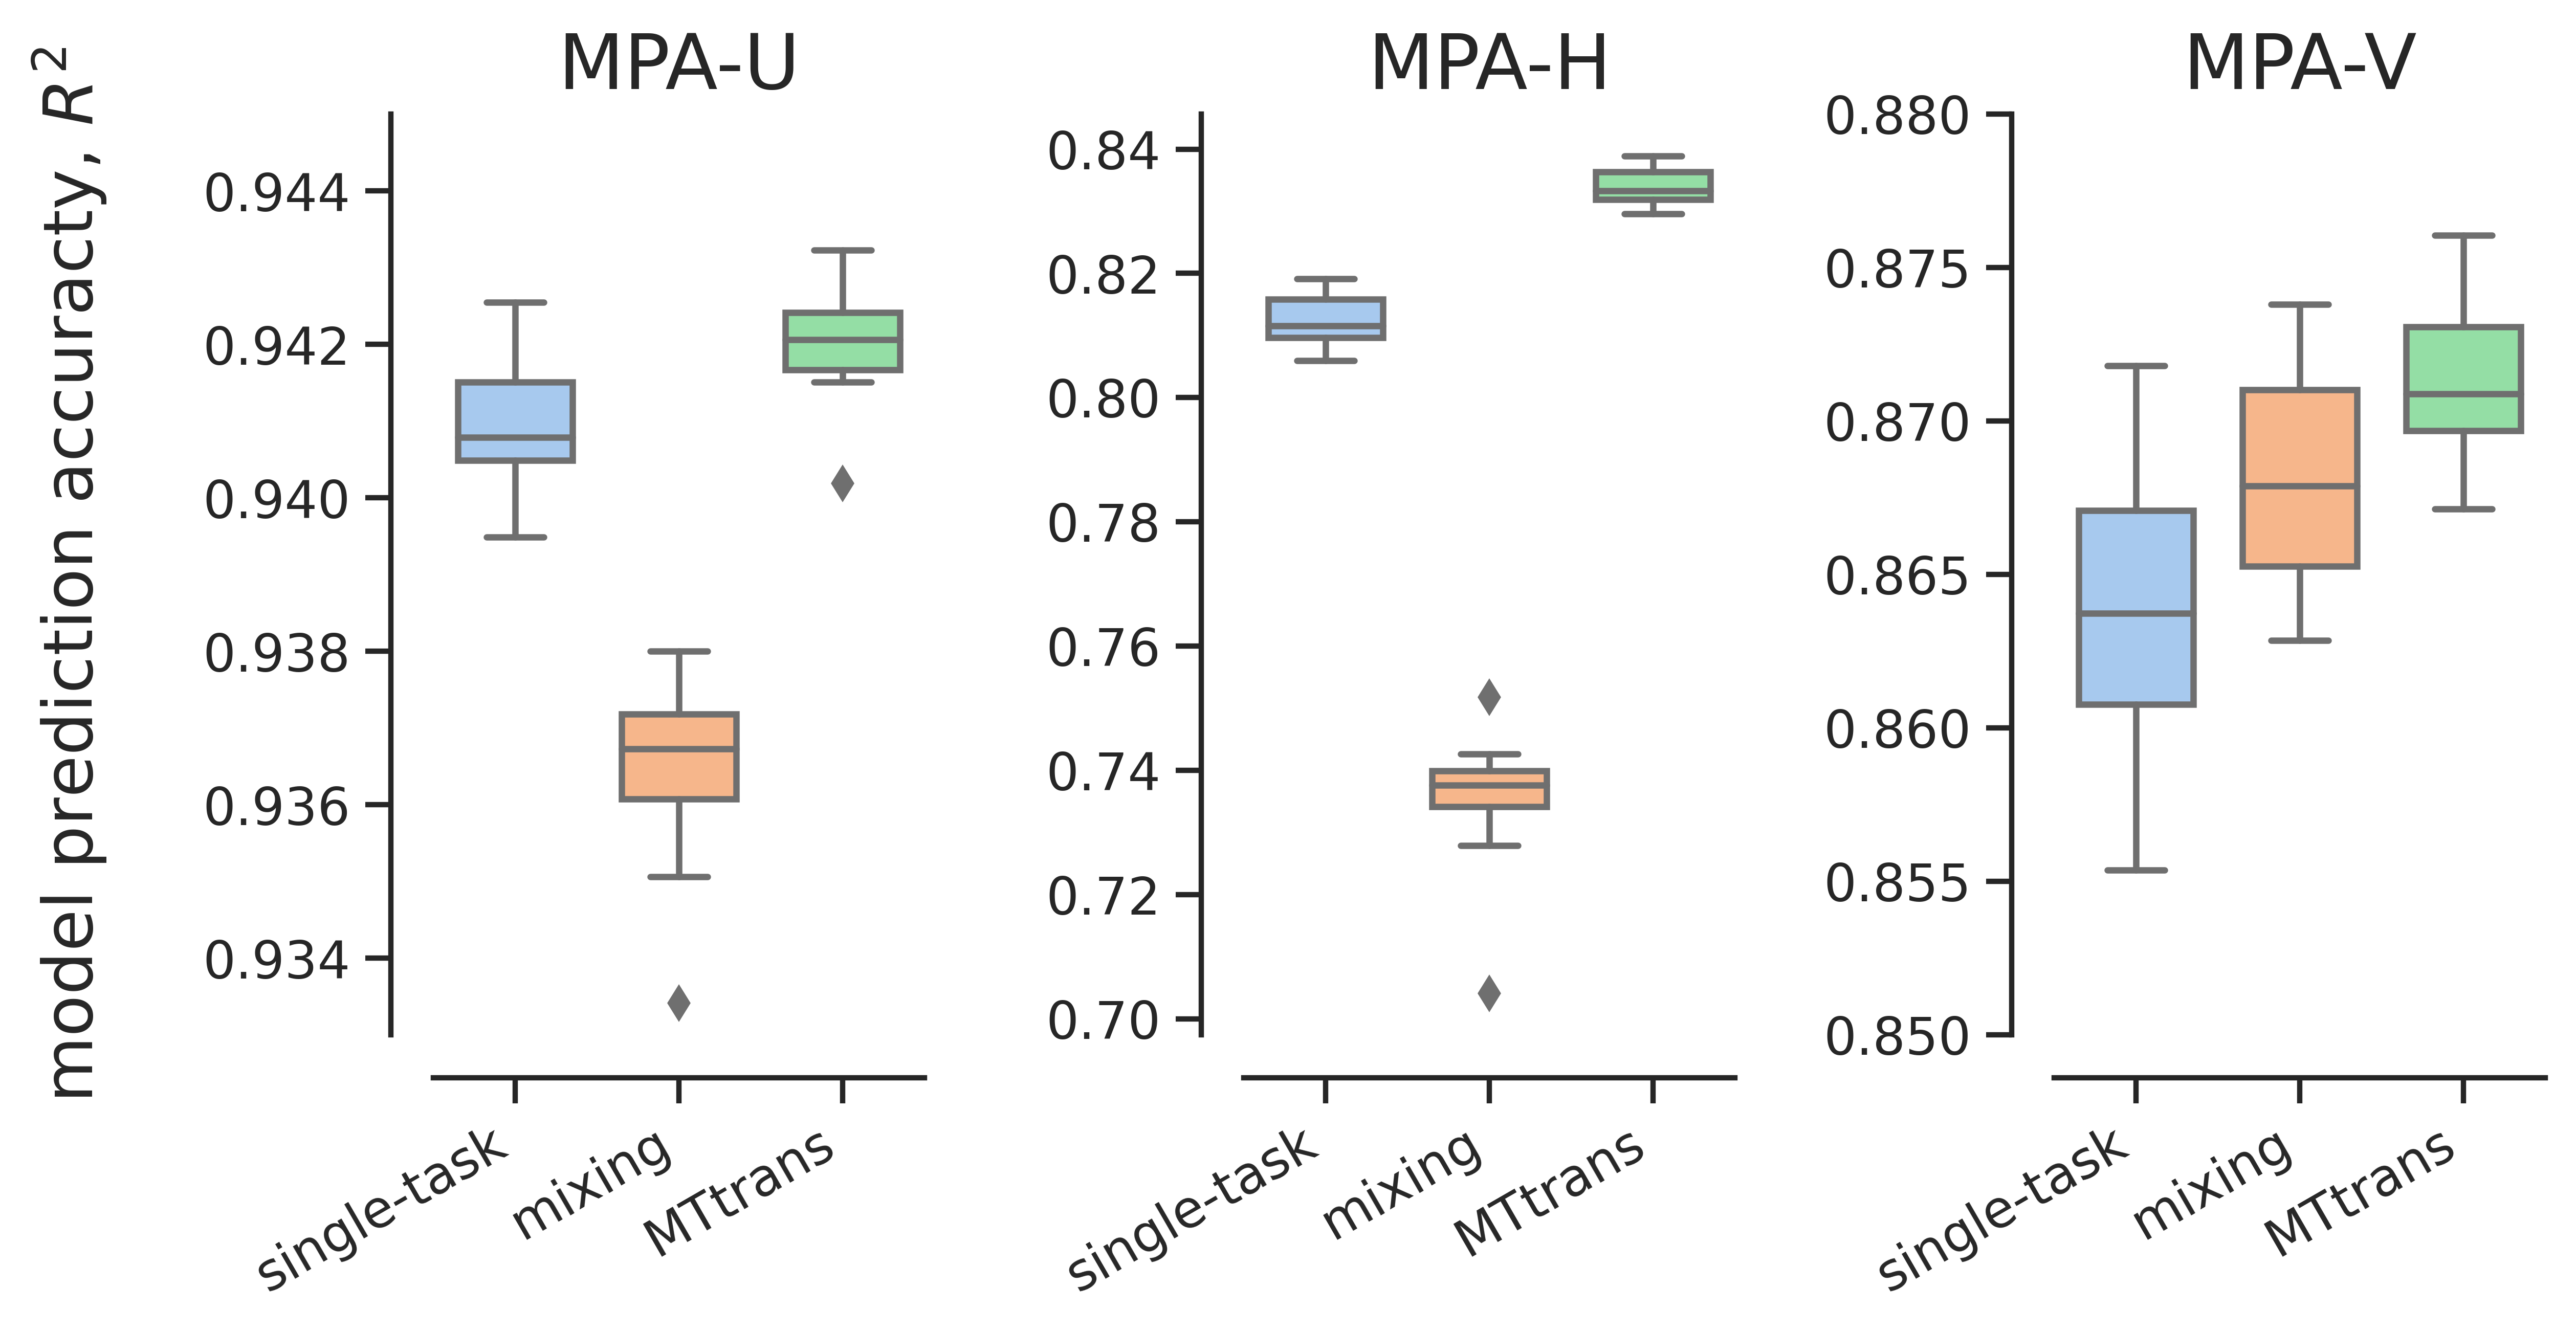

In [8]:
fig  = plt.figure(figsize=(8,3), dpi=600)

axs = []
for i in range(3):
    axs.append(fig.add_axes([0+0.33*i, 0, 0.2, 1]))

for i, task in enumerate(['unmod1', 'human', 'vleng']):
    
    cols = [col for col in all_df.columns if task in col]
    sns.boxplot(data=all_df[cols], ax=axs[i], width=0.7, saturation=.85)
for i ,task in enumerate(['MPA-U', 'MPA-H', 'MPA-V']):
    axs[i].set_title(task,fontsize=18)
    

axs[0].set_ylim(0.933,0.945)
axs[2].set_ylim(0.85,0.88)


for i, task in enumerate(['unmod1', 'human', 'vleng']):
    sns.despine(offset=10, trim=False, ax=axs[i])
    axs[i].set_xticklabels(['single-task', 'mixing', r'MTtrans'], rotation=30, ha='right')

axs[0].set_ylabel(r'model prediction accuracty, $R^2$'+'\n', fontsize=16)

# Fig 2 B

## forward

In [8]:

def pipeline_yeast(config_file, which_set=2, device='cpu', kfold_index=None):
    
    device = torch.device('cuda:%s'%device) if type(device)==int else 'cpu'
    config_file = os.path.join("/ssd/users/wergillius/Project/UTR_VAE/", config_file)
    POPEN = Auto_popen(config_file)
    POPEN.kfold_index = kfold_index
    
    loader_set =reader.get_dataloader(POPEN)
    model = reload_model(config_file, device, kfold_index)
    
    dataloader = loader_set[which_set]
    y_true_f, y_pred_f = val_a_epoch(model, dataloader, device)
    r2 = r2_score(y_true_f,y_pred_f)
    
    del model
    
    return r2

In [9]:
config = 'log/Backbone/RL_gru_GSE104252/scratch_schedule_kfold/from_scratch.ini'
r2_list = [pipeline_yeast(config, 2, 3, k) for k in range(10)]

100%|██████████| 765/765 [00:10<00:00, 73.08it/s] 


In [ ]:
config = 'log/Backbone/RL_gru_GSE104252/MDL_pretrain/MDL.ini'
MDL_r2 = [pipeline_yeast(config, 2, 'cpu', k) for k in range(10)]

100%|██████████| 765/765 [00:11<00:00, 64.64it/s]


## integrate

In [19]:
config = 'log/Backbone/RL_gru_GSE104252/unmod_pretrain/unmod.ini'
unmod1_r2 = [pipeline_yeast(config, 2, 3, k) for k in range(10)]

config = 'log/Backbone/RL_gru_GSE104252/human_pretrain/human.ini'
human_r2 = [pipeline_yeast(config, 2, 3, k) for k in range(10)]

config = 'log/Backbone/RL_gru_GSE104252/vleng_pretrain/vleng.ini'
vleng_r2 = [pipeline_yeast(config, 2, 3, k) for k in range(10)]

100%|██████████| 765/765 [00:05<00:00, 149.89it/s]


In [32]:
yeast_df = pd.DataFrame({"scratch":r2_list, "MTL_transfer":MDL_r2, "unmod1_transfer":unmod1_r2, "human_transfer":human_r2, "vleng_transfer":vleng_r2})

In [33]:
yeast_df  = yeast_df[['human_transfer', 'vleng_transfer', 'unmod1_transfer', 'MTL_transfer', 'scratch']]

In [40]:
yeast_df.to_csv("yeast_performance.csv",index=False)

## plot

In [37]:
sns.set_theme(palette="pastel", style='ticks',font_scale=1.8)

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(30,13), dpi=600)
for i, task in enumerate(['unmod1', 'human', 'vleng']):
    
    cols = [col for col in all_df.columns if task in col]
    sns.boxplot(data=all_df[cols], ax=axs[i])
    axs[i].set_xticklabels(['single-task', 'mixing', 'multi-task'])
    axs[i].set_title(task,fontsize=25)
    sns.despine(offset=10, trim=False, ax=axs[i])
axs[2].set_ylim(0.855,0.88)

sns.boxplot(data=yeast_df,ax=axs[3])
axs[3].set_xticklabels(['human', 'vleng', 'unmod1', "MTL", 'Scartch'])
axs[3].set_title("yeast ",fontsize=25)
axs[0].set_ylabel(r'Spearman corelation, $p$'+'\n')
sns.despine(offset=10, trim=False, ax=axs[3])

In [9]:
yeast_df = pd.read_csv("yeast_performance.csv")

In [43]:
sns.set_theme(palette="pastel", style='ticks',font_scale=1)
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

Text(-0.22, 4.6, '$scratch$')

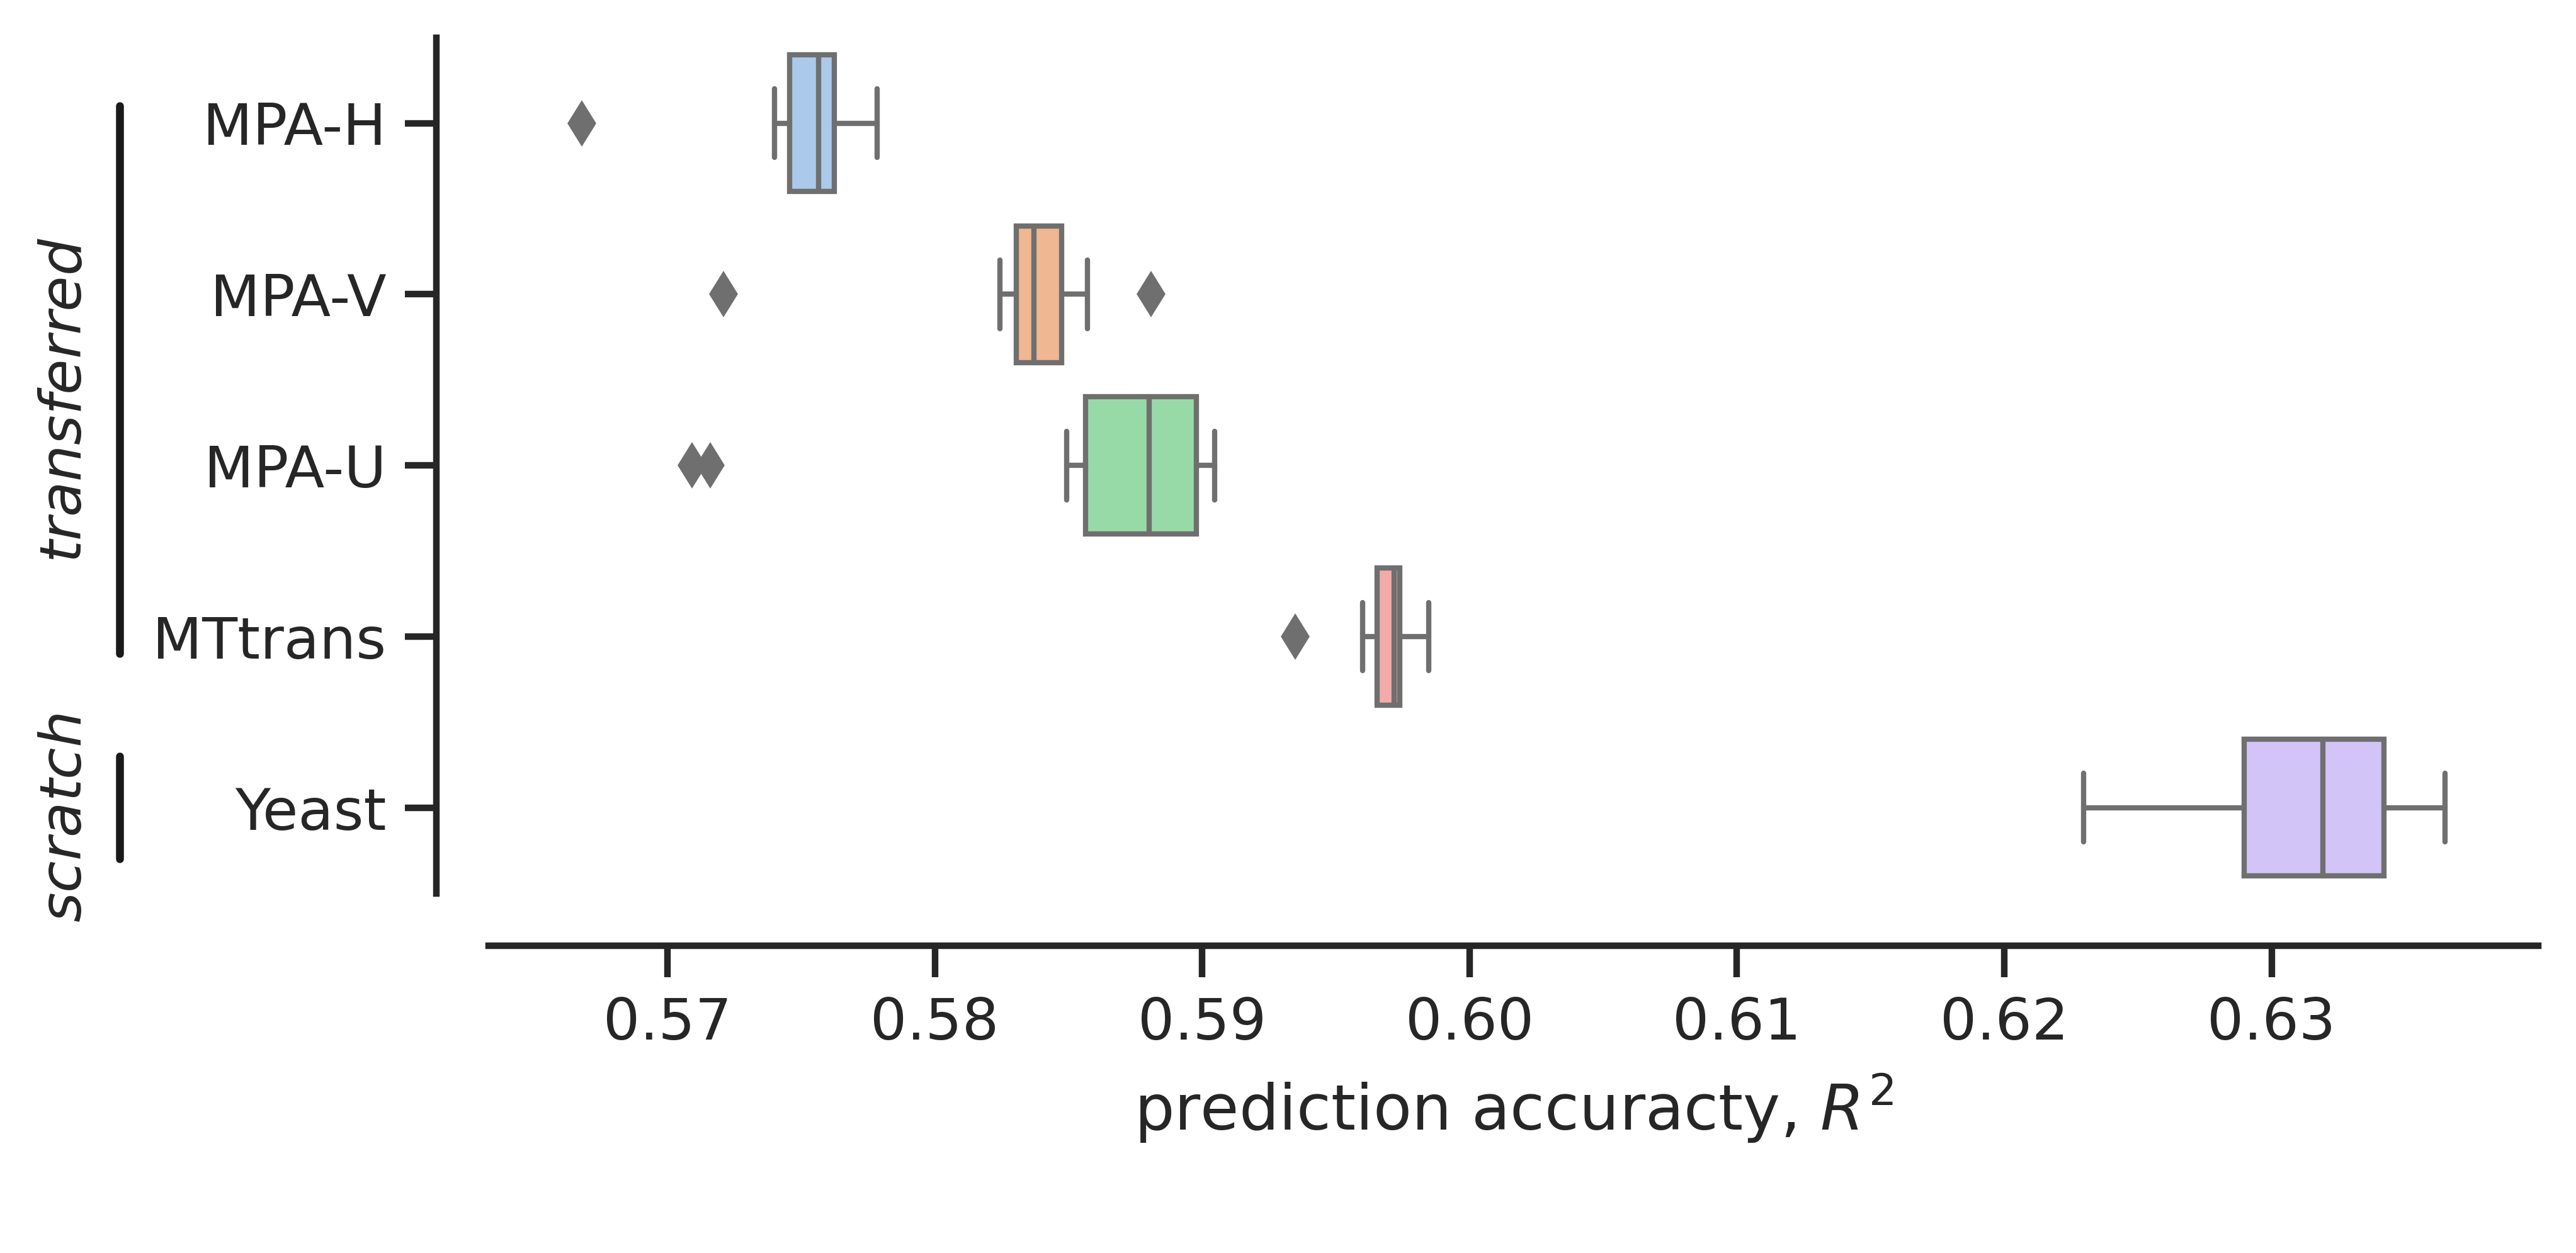

In [95]:
fig, axs = plt.subplots(1,1,figsize=(7,3), dpi=600)

sns.boxplot(data=yeast_df,ax=axs, linewidth=1, orient='h')
sns.despine(offset=10, trim=False, ax=axs)
axs.set_yticklabels(['MPA-H', 'MPA-V', 'MPA-U', "MTtrans", 'Yeast'], ha='right')
# axs.set_title("yeast ",fontsize=17)
axs.set_xlabel(r'prediction accuracty, $R^2$'+'\n')

axs.add_line(Line2D([-0.18, -0.18],[-0.1,3.1],transform=axs.get_yaxis_transform(),
                               color="k", clip_on=False))
axs.text(-0.22, 2.5, r'$transferred$',transform=axs.get_yaxis_transform(),
         fontsize=11, rotation=90)

axs.add_line(Line2D([-0.18, -0.18],[3.7, 4.3],transform=axs.get_yaxis_transform(),
                               color="k", clip_on=False))
axs.text(-0.22, 4.6, r'$scratch$', transform=axs.get_yaxis_transform(),
         fontsize=11, rotation=90)

# Fig 2 C

## multitask and transfer

In [9]:
from scipy import stats

## tasks

In [489]:
tasks = ['Andrev2015', 'muscle', 'pc3']

In [490]:
celline_scratch = {task:[] for task in ['Andrev2015', 'muscle', 'pc3']}
for k in range(10):
    config_file = 'log/Backbone/RL_celline/adam_MTL_log_te/adam_logte.ini'
    dictt = pipeline_cell_line(config_file, which_set=2, device='cpu', kfold_index=k)
    for t, value in celline_scratch.items():
        value.append(dictt[t])

100%|██████████| 108/108 [00:01<00:00, 82.03it/s]


In [491]:
pretrain_relax = {task:[] for task in ['Andrev2015','muscle','pc3']}

for k in range(10):
    config_file = 'log/Backbone/RL_celline/MDL_pretrain_relax/pretrain_relax.ini'
    dictt = pipeline_cell_line(config_file, which_set=2, device='cpu', kfold_index=k)
    for t, value in pretrain_relax.items():
        value.append(dictt[t])

100%|██████████| 108/108 [00:01<00:00, 75.42it/s] 


In [492]:
schedule_MTL = {task:[] for task in ['Andrev2015','muscle','pc3']}

for k in range(10):
    config_file = 'log/Backbone/RL_celline/schedule_MTL_log_te/schedule_MTL.ini'
    dictt = pipeline_cell_line(config_file, which_set=2, device='cpu', kfold_index=k)
    for t, value in schedule_MTL.items():
        value.append(dictt[t])

100%|██████████| 108/108 [00:01<00:00, 75.74it/s] 


In [493]:
Andrev_single = []
for k in range(10):
    r2 = singletask_cell_line('log/Backbone/RL_gru_3DS/Andrev_single_task/log_te_cv.ini', which_set=2, device='cpu', kfold_index=k)
    Andrev_single.append(r2)

100%|██████████| 123/123 [00:01<00:00, 68.60it/s] 


In [494]:
muscle_single = []
for k in range(10):
    r2 = singletask_cell_line('log/Backbone/RL_gru_3DS/muscle_single_task/log_te_cv.ini', which_set=2, device='cpu', kfold_index=k)
    muscle_single.append(r2)

100%|██████████| 10/10 [00:00<00:00, 13.18it/s]


In [495]:
pc3_single = []
for k in range(10):
    r2 = singletask_cell_line('log/Backbone/RL_gru_3DS/pc3_single_task/log_te_cv.ini', which_set=2, device='cpu', kfold_index=k)
    pc3_single.append(r2)

100%|██████████| 107/107 [00:01<00:00, 62.00it/s]


## RF baseline

```ini
[Andrev2015]
RF model 0: 0.4924657212605863 
RF model 1: 0.5281069064582427 
RF model 2: 0.530928668110778 
RF model 3: 0.5489315401113655 
RF model 4: 0.5304438965685636 
RF model 5: 0.5253012636835631 
RF model 6: 0.5248564256078839 
RF model 7: 0.5138097617207024 
RF model 8: 0.5224129072284471 
RF model 9: 0.519344227291114 

[muscle]
RF model 0: 0.547566411902818 
RF model 1: 0.6028934072347887 
RF model 2: 0.5466940278158777 
RF model 3: 0.5598195354385015 
RF model 4: 0.6988736149307381 
RF model 5: 0.5530874986059995 
RF model 6: 0.4436371888563208 
RF model 7: 0.5683980917196295 
RF model 8: 0.5165763446687439 
RF model 9: 0.6730851953879395 

[pc3]
RF model 0: 0.5822413059055946 
RF model 1: 0.5713791713338693 
RF model 2: 0.5736660317091482 
RF model 3: 0.5863706242688773 
RF model 4: 0.5626639113217776 
RF model 5: 0.5413885293348174 
RF model 6: 0.5476142108387254 
RF model 7: 0.5736922150042232 
RF model 8: 0.5683095375450803 
RF model 9: 0.5644011672625084 
```

Andrev2015 = [0.4924657212605863, 
                0.5281069064582427,
                0.530928668110778, 
                0.5489315401113655, 
                0.5304438965685636, 
                0.5253012636835631, 
                0.5248564256078839, 
                0.5138097617207024, 
                0.5224129072284471, 
                0.519344227291114] 

muscle = [0.547566411902818, 
            0.6028934072347887, 
            0.5466940278158777, 
            0.5598195354385015, 
            0.6988736149307381, 
            0.5530874986059995, 
            0.4436371888563208, 
            0.5683980917196295, 
            0.5165763446687439, 
            0.6730851953879395]

pc3 = [0.5822413059055946, 
        0.5713791713338693, 
        0.5736660317091482, 
        0.5863706242688773, 
        0.5626639113217776, 
        0.5413885293348174, 
        0.5476142108387254, 
        0.5736922150042232, 
        0.5683095375450803, 
        0.5644011672625084]

In [497]:
Andrev2015 = [0.4924657212605863, 0.5281069064582427, 0.530928668110778, 0.5489315401113655, 0.5304438965685636, 0.5253012636835631, 0.5248564256078839, 0.5138097617207024, 0.5224129072284471, 0.519344227291114]

muscle = [0.547566411902818, 0.6028934072347887, 0.5466940278158777, 0.5598195354385015, 0.6988736149307381, 0.5530874986059995, 0.4436371888563208, 0.5683980917196295, 0.5165763446687439, 0.6730851953879395]

pc3 = [0.5822413059055946, 0.5713791713338693, 0.5736660317091482, 0.5863706242688773, 0.5626639113217776, 0.5413885293348174, 0.5476142108387254, 0.5736922150042232, 0.5683095375450803, 0.5644011672625084]

In [498]:
cellline_df = pd.DataFrame({'Andrev2015':Andrev2015, 'muscle':muscle, 'pc3':pc3})

In [499]:
pretrain = pd.DataFrame(pretrain_relax)
pretrain.columns = ['pretrain_'+col for col in pretrain.columns]

scratch = pd.DataFrame(schedule_MTL)
scratch.columns = ['scratch_'+col for col in scratch.columns]

In [500]:
pc3_single

[0.6261146046755312,
 0.6455717780336084,
 0.6280021502604668,
 0.6191832672515893,
 0.5994788348291581,
 0.5443297151949065,
 0.6405177399485841,
 0.6409295086575133,
 0.6649200010595442,
 0.6339195429871567]

In [501]:
muscle_single

[0.5910674042240102,
 0.5624750415862844,
 0.5545300178171422,
 0.5605096204965402,
 0.6321884581899986,
 0.566819108341178,
 0.5840877286226221,
 0.5896193819723788,
 0.6089749599833922,
 0.5807506797405655]

In [502]:
single = pd.DataFrame({'Andrev2015': Andrev_single , 'muscle': muscle_single , 'pc3': pc3_single})
single.columns = ['single_'+col for col in single.columns]

In [503]:
celline_df = pd.concat([cellline_df,single, scratch, pretrain], axis=1)

In [505]:
celline_df.to_csv('FIG3_3cellline_permformance.csv', index=False)

## plot

In [23]:
import seaborn as sns

In [97]:
celline_df = pd.read_csv('FIG3_3cellline_permformance.csv')

In [98]:
sns.set_theme(style='ticks', palette="pastel", font_scale=1.5)

In [99]:
tasks = ['muscle', 'Andrev2015', 'pc3']

Text(0, 0.5, 'Spearman corelation, $p$\n')

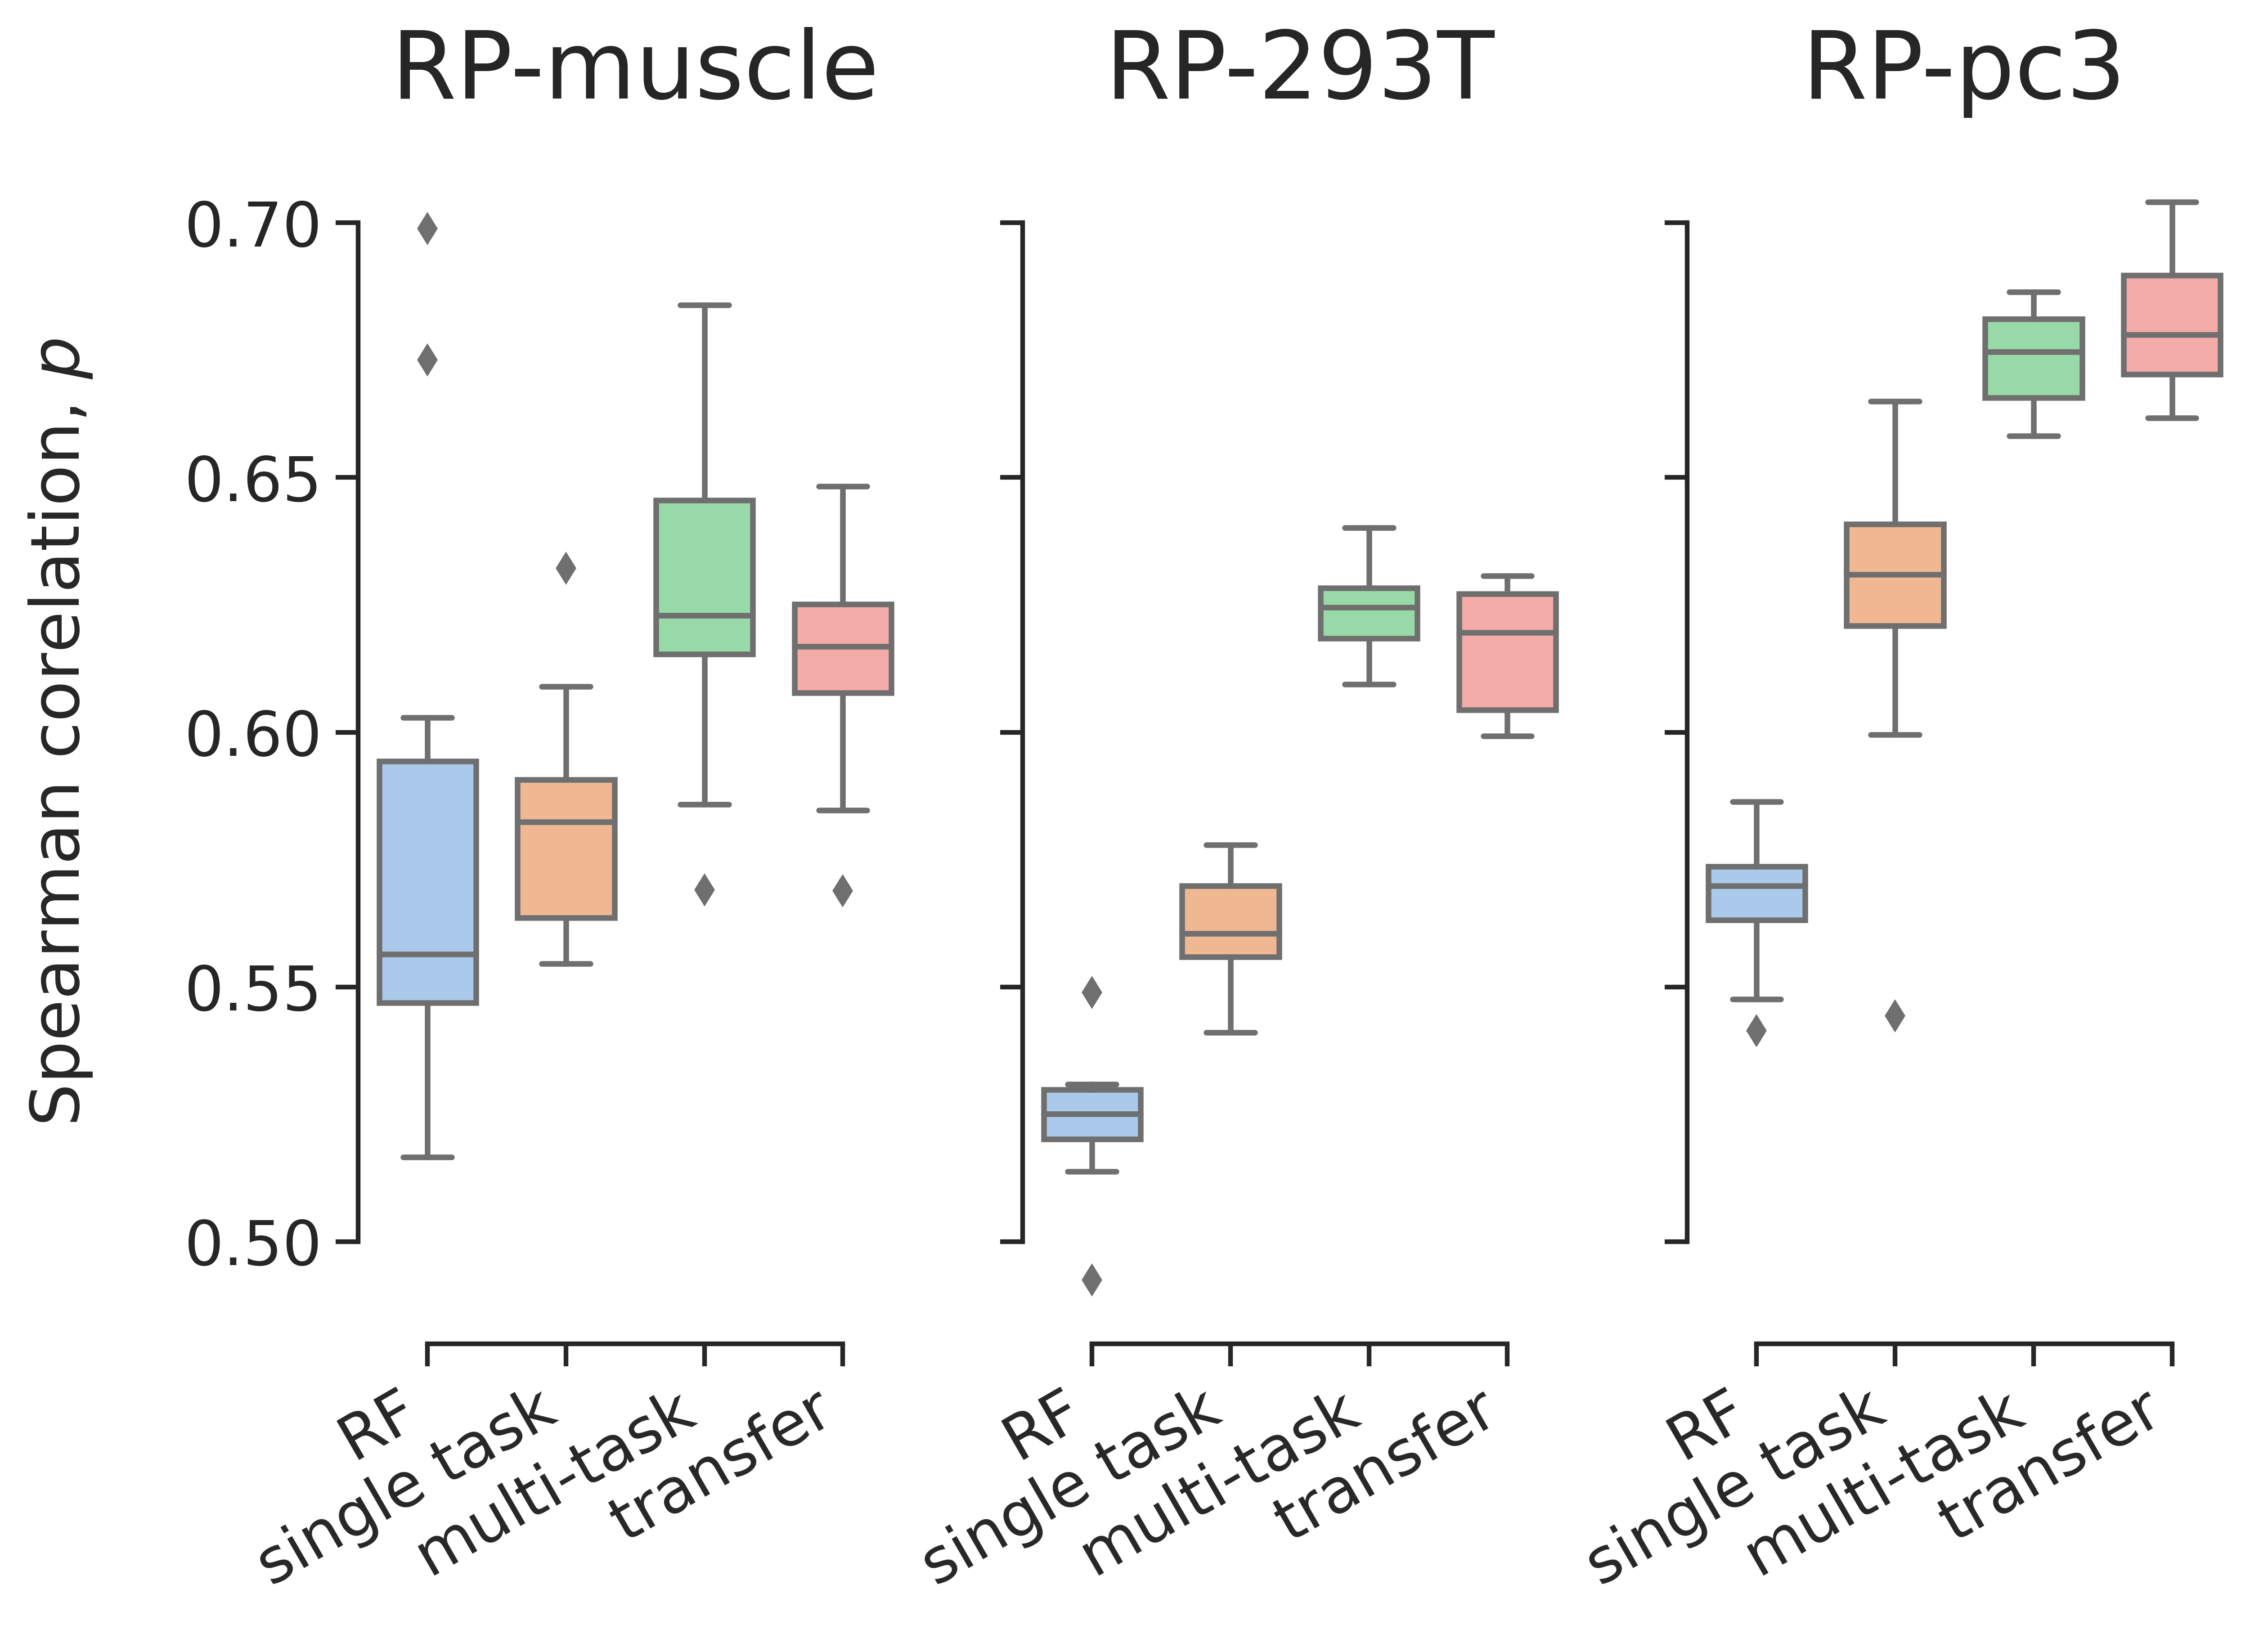

In [100]:
fig, axs = plt.subplots(1,3, figsize=(9,6), dpi=600, sharey=True)
for i, task in enumerate(tasks):
    
    axs[i].set_ylim(0.48, 0.72)
    cols = [col for col in celline_df.columns if task in col]
    sns.boxplot(data=celline_df[cols], ax=axs[i], width=0.7)
    sns.despine(offset=0.1, trim=True, ax=axs[i])
    axs[i].set_xticklabels(labels=['RF', 'single task', 'multi-task', 'transfer'], ha='right', rotation= 30)
    
for i, task in enumerate(['RP-muscle', 'RP-293T', 'RP-pc3']):
    axs[i].set_title(task,fontsize=25)
axs[0].set_ylabel(r'Spearman corelation, $p$'+'\n')

In [359]:
transfer = [0.8915551918210738, 0.7824691144340565, 0.8558836449455097]

muscle = [0.779487,0.664968, 0.734561,0.743242, 0.674570, 0.667419,0.747756,0.683884,0.733356,0.711558]

HEK = [0.648189,0.660934,0.617841,0.648385,0.652521,0.618487,0.620484,0.653222,0.646648,0.653515]
pc3 = [0.681493,0.670005,0.683072,0.670842,0.701247,0.675444,0.699005,0.707599,0.689475,0.673914]

fil_w_na = lambda x : np.array(x+[np.nan]*7)

dup_data = pd.DataFrame({'transfer_Andrev':fil_w_na(transfer),'dup_Andrev':HEK, 'dup_muscle':muscle, 'dup_pc3':pc3 })

In [362]:
de_dup = pd.concat([celline_df[['Andrev2015','muscle','pc3']],dup_data],axis=1)

<AxesSubplot:>

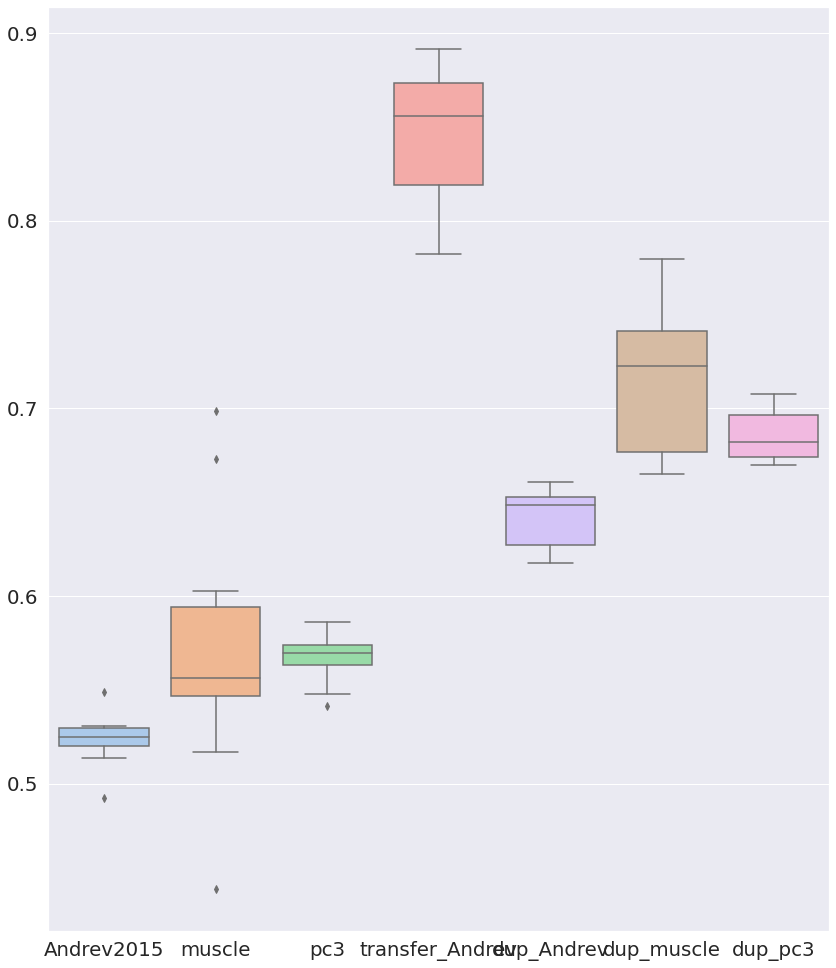

In [365]:
plt.figure(figsize=(14,17))
sns.boxplot(data=de_dup)

# RL 6 data

## collecting data

In [12]:
def testset_result( json , model_name):
    """
    convert prediction result dict in test set to seaborn favourable dataset
    
    Args:
        json : [dict]  , list of dict { 'task' : values}
        model_name : the model used to predict
    Return:
        df
    """
    tiddy_data = np.concatenate([np.stack(dic.items()) for dic in json])
    df = pd.DataFrame(tiddy_data,columns=['task','sp_r'])
    df['sp_r'] =df.sp_r.astype(float).apply(round, args=(3,))
    df['model'] = model_name
    df['R2'] = df.sp_r.apply(lambda x: x**2)
    return df

# order : 3 C -> 3 C 1sH-> 2 C 1SH -> 2 cellline_Human -> 2 cellline 2 sub -> 2c2M ->3C3M -> 3M

## 3C

In [7]:
C3 = pd.read_csv('FIG3_3cellline_permformance.csv')

In [8]:
C3_df = pd.DataFrame([])
for column in ['Andrev2015', 'muscle', 'pc3']:
    tmp = C3[[column]].copy().rename({column:'spr'}, axis=1)
    tmp['task'] = column
    
    C3_df = C3_df.append(tmp)
C3_df['model'] = 'RL_3_cell'
C3_df['R2'] = C3_df['spr'].values**2

In [9]:
C3_df.head(3)

,spr,task,model,R2
0,0.492466,Andrev2015,RL_3_cell,0.242522
1,0.528107,Andrev2015,RL_3_cell,0.278897
2,0.530929,Andrev2015,RL_3_cell,0.281885


## 3C 1sH

In [13]:
SubHuman_3C = []
config_file = 'log/Backbone/RL_6_data/1M3C/SubHuman_3C_1.ini'
for i in range(4):
    SubHuman_3C.append(pipeline_cell_line(config_file, which_set=2, device = 1, kfold_index=i, expand_MAP=True))

SubHuman_3C_data = testset_result(SubHuman_3C, 'SubHuman_3C')

/tmp/ipykernel_140998/1192887844.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  SubHuman_3C_data = testset_result(SubHuman_3C, 'SubHuman_3C')


In [14]:
print(SubHuman_3C_data.task.unique())
SubHuman_3C_data.head(4)

['SubHuman' 'Andrev2015' 'vleng' 'pc3' 'muscle' 'unmod1']


,task,sp_r,model,R2
0,SubHuman,0.821,SubHuman_3C,0.674041
1,Andrev2015,0.627,SubHuman_3C,0.393129
2,vleng,0.721,SubHuman_3C,0.519841
3,pc3,0.689,SubHuman_3C,0.474721


## 2C 1SH

In [15]:
SubHuman_no_M = []
config_file = 'log/Backbone/RL_6_data/SubHuman_Andrev_pc3_10fold/SubHuman_no_muscle.ini'
for i in range(1,5):
    SubHuman_no_M.append(pipeline_cell_line(config_file, which_set=2, device=1, kfold_index=i ,expand_MAP=True))

100%|██████████| 625/625 [00:03<00:00, 176.21it/s]


In [16]:
SubHuman_no_M = testset_result(SubHuman_no_M, 'SubHuman_no_M')
SubHuman_no_M['R2'] = SubHuman_no_M.sp_r.apply(lambda x: x**2)
SubHuman_no_M

/tmp/ipykernel_140998/845107373.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  SubHuman_no_M = testset_result(SubHuman_no_M, 'SubHuman_no_M')


,task,sp_r,model,R2
0,SubHuman,0.816,SubHuman_no_M,0.665856
1,Andrev2015,0.626,SubHuman_no_M,0.391876
2,vleng,0.666,SubHuman_no_M,0.443556
3,pc3,0.688,SubHuman_no_M,0.473344
4,unmod1,0.806,SubHuman_no_M,0.649636
5,SubHuman,0.800,SubHuman_no_M,0.640000
6,Andrev2015,0.633,SubHuman_no_M,0.400689
7,vleng,0.646,SubHuman_no_M,0.417316
8,pc3,0.668,SubHuman_no_M,0.446224
9,unmod1,0.796,SubHuman_no_M,0.633616


## 2C 1H

In [17]:
Human_no_M = []
config_file = 'log/Backbone/RL_6_data/task_lambda/Human_no_M.ini'
for i in range(3):
    Human_no_M.append(pipeline_cell_line(config_file, which_set=2, device=1, kfold_index=i, expand_MAP=True))
Human_nM_data =  testset_result(Human_no_M, 'Human_no_M')

100%|██████████| 625/625 [00:04<00:00, 156.13it/s]
/tmp/ipykernel_140998/1581017463.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Human_nM_data =  testset_result(Human_no_M, 'Human_no_M')


In [18]:
Human_nM_data.head(4)

,task,sp_r,model,R2
0,Andrev2015,0.648,Human_no_M,0.419904
1,vleng,0.759,Human_no_M,0.576081
2,human,0.870,Human_no_M,0.756900
3,pc3,0.699,Human_no_M,0.488601


## 2C 2sub

In [19]:
S2C2 = []
config_file = 'log/Backbone/RL_6_data/task_lambda/2Sub2cell_weightpc3.ini'
for i in range(4):
    S2C2.append(pipeline_cell_line(config_file, which_set=2, device=2, kfold_index=i ,expand_MAP=False))

100%|██████████| 108/108 [00:01<00:00, 104.85it/s]


In [20]:
S2C2_data = testset_result(S2C2, '2Sub2cell')
S2C2_data.head(3)

/tmp/ipykernel_140998/2943254853.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  S2C2_data = testset_result(S2C2, '2Sub2cell')


,task,sp_r,model,R2
0,SubHuman,0.821,2Sub2cell,0.674041
1,Andrev2015,0.578,2Sub2cell,0.334084
2,SubVleng,0.807,2Sub2cell,0.651249


## 2C 1Sv 1H

In [21]:
SUH_AP = []
config_file = 'log/Backbone/RL_6_data/1M1SM2C/SUH_AP_2_reorderd.ini'
for i in range(4):
    SUH_AP.append(pipeline_cell_line(config_file, which_set=2, device = 1, kfold_index=i ,expand_MAP=True))

100%|██████████| 625/625 [00:03<00:00, 156.56it/s]


In [22]:
SUH_AP_data = testset_result(SUH_AP, 'SvH_AP')
SUH_AP_data.head(3)

/tmp/ipykernel_140998/3886795595.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  SUH_AP_data = testset_result(SUH_AP, 'SvH_AP')


,task,sp_r,model,R2
0,Andrev2015,0.599,SvH_AP,0.358801
1,SubVleng,0.821,SvH_AP,0.674041
2,vleng,0.800,SvH_AP,0.640000


## RL6

In [23]:
RL6 = []
config_file = 'log/Backbone/RL_6_data/test_run/schedule_lr.ini'
for i in range(6):
    RL6.append(pipeline_cell_line(config_file, which_set=2, device=1, kfold_index=i ,expand_MAP=True))

100%|██████████| 625/625 [00:04<00:00, 151.53it/s]


In [24]:
RL6_df = testset_result(RL6, 'RL_6_data')
RL6_df['R2'] = RL6_df.sp_r.apply(lambda x: x**2)

RL6_df.head(6)

/tmp/ipykernel_140998/1162138725.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  RL6_df = testset_result(RL6, 'RL_6_data')


,task,sp_r,model,R2
0,Andrev2015,-0.030,RL_6_data,0.000900
1,vleng,0.898,RL_6_data,0.806404
2,human,0.905,RL_6_data,0.819025
3,pc3,-0.132,RL_6_data,0.017424
4,muscle,0.106,RL_6_data,0.011236
5,unmod1,0.955,RL_6_data,0.912025


## 3MAP

In [25]:
M3 = pd.read_csv('FIG2_performance.csv')

In [26]:
M3_df = pd.DataFrame([])
for column in ['MTL_unmod1', 'MTL_human', 'MTL_vleng']:
    
    tmp_df = M3[[column]].copy().rename({column:'R2'},axis=1)
    tmp_df['task'] = column.split('_')[1]
    
    M3_df = M3_df.append(tmp_df)

In [27]:
M3_df['model'] = 'RL_3_MAP'

## integrating all

in the order of 
3 C -> 3 C 1sH-> 2 C 1SH -> 2 cellline_Human -> 2 cellline 2 sub -> 2c2M ->3C3M -> 3M

In [28]:
all_result = pd.DataFrame([])

for df in [C3_df,SubHuman_3C_data, SubHuman_no_M, Human_nM_data, S2C2_data, SUH_AP_data, RL6_df, M3_df]:
    all_result = all_result.append(df)

all_result['task'] = all_result.task.apply(lambda x : x.replace('SubHuman','human'))
all_result['task'] = all_result.task.apply(lambda x : x.replace('SubVleng','vleng'))

In [41]:
all_result.shape

(195, 6)

In [43]:
np.sum(all_result.model == 'RL_3_MAP')

30

In [30]:
content_dict = dict(zip(all_result.model.unique(), range(8)))
all_result['content_of_MAP'] = all_result.model.apply(lambda x: content_dict[x])

In [31]:
all_result.index = range(all_result.shape[0])

# ploting Fig 3 C

## dataset size 

In [32]:
datasize={'unmod1':280000, 'human':100000, 'vleng':100000, 'muscle':1200, 'pc3':13000, 'Andrev2015':15000}

In [33]:
datasize.keys()

dict_keys(['unmod1', 'human', 'vleng', 'muscle', 'pc3', 'Andrev2015'])

In [34]:
size = np.array([v for v in datasize.values()]).reshape(-1,1)

In [35]:
size.shape

(6, 1)

In [36]:
model_use = np.array([
                [0, 0,   0,   1, 1, 1],      # 3C
                [0, 0.1, 0,   1, 1, 1],      # 1sH3C
                [0, 0.1, 0,   0, 1, 1],      # 1SM2C
                [0, 1,   0,   0, 1, 1],      # 1M2C
                [0, 0.1, 0.1, 0, 1, 1],  # 2SM2C
                [0, 1,   0.1, 0, 1, 1],    # 2SvH2C
                [1, 1,   1,   1, 1, 1],      # 3M3C
                [1, 1,   1,   0, 0, 0],      # 3M 
            ])

In [37]:
data_usage = np.multiply(model_use, size.T)

In [38]:
data_usage

array([[     0.,      0.,      0.,   1200.,  13000.,  15000.],
       [     0.,  10000.,      0.,   1200.,  13000.,  15000.],
       [     0.,  10000.,      0.,      0.,  13000.,  15000.],
       [     0., 100000.,      0.,      0.,  13000.,  15000.],
       [     0.,  10000.,  10000.,      0.,  13000.,  15000.],
       [     0., 100000.,  10000.,      0.,  13000.,  15000.],
       [280000., 100000., 100000.,   1200.,  13000.,  15000.],
       [280000., 100000., 100000.,      0.,      0.,      0.]])

## ploting

In [54]:
from matplotlib import patches

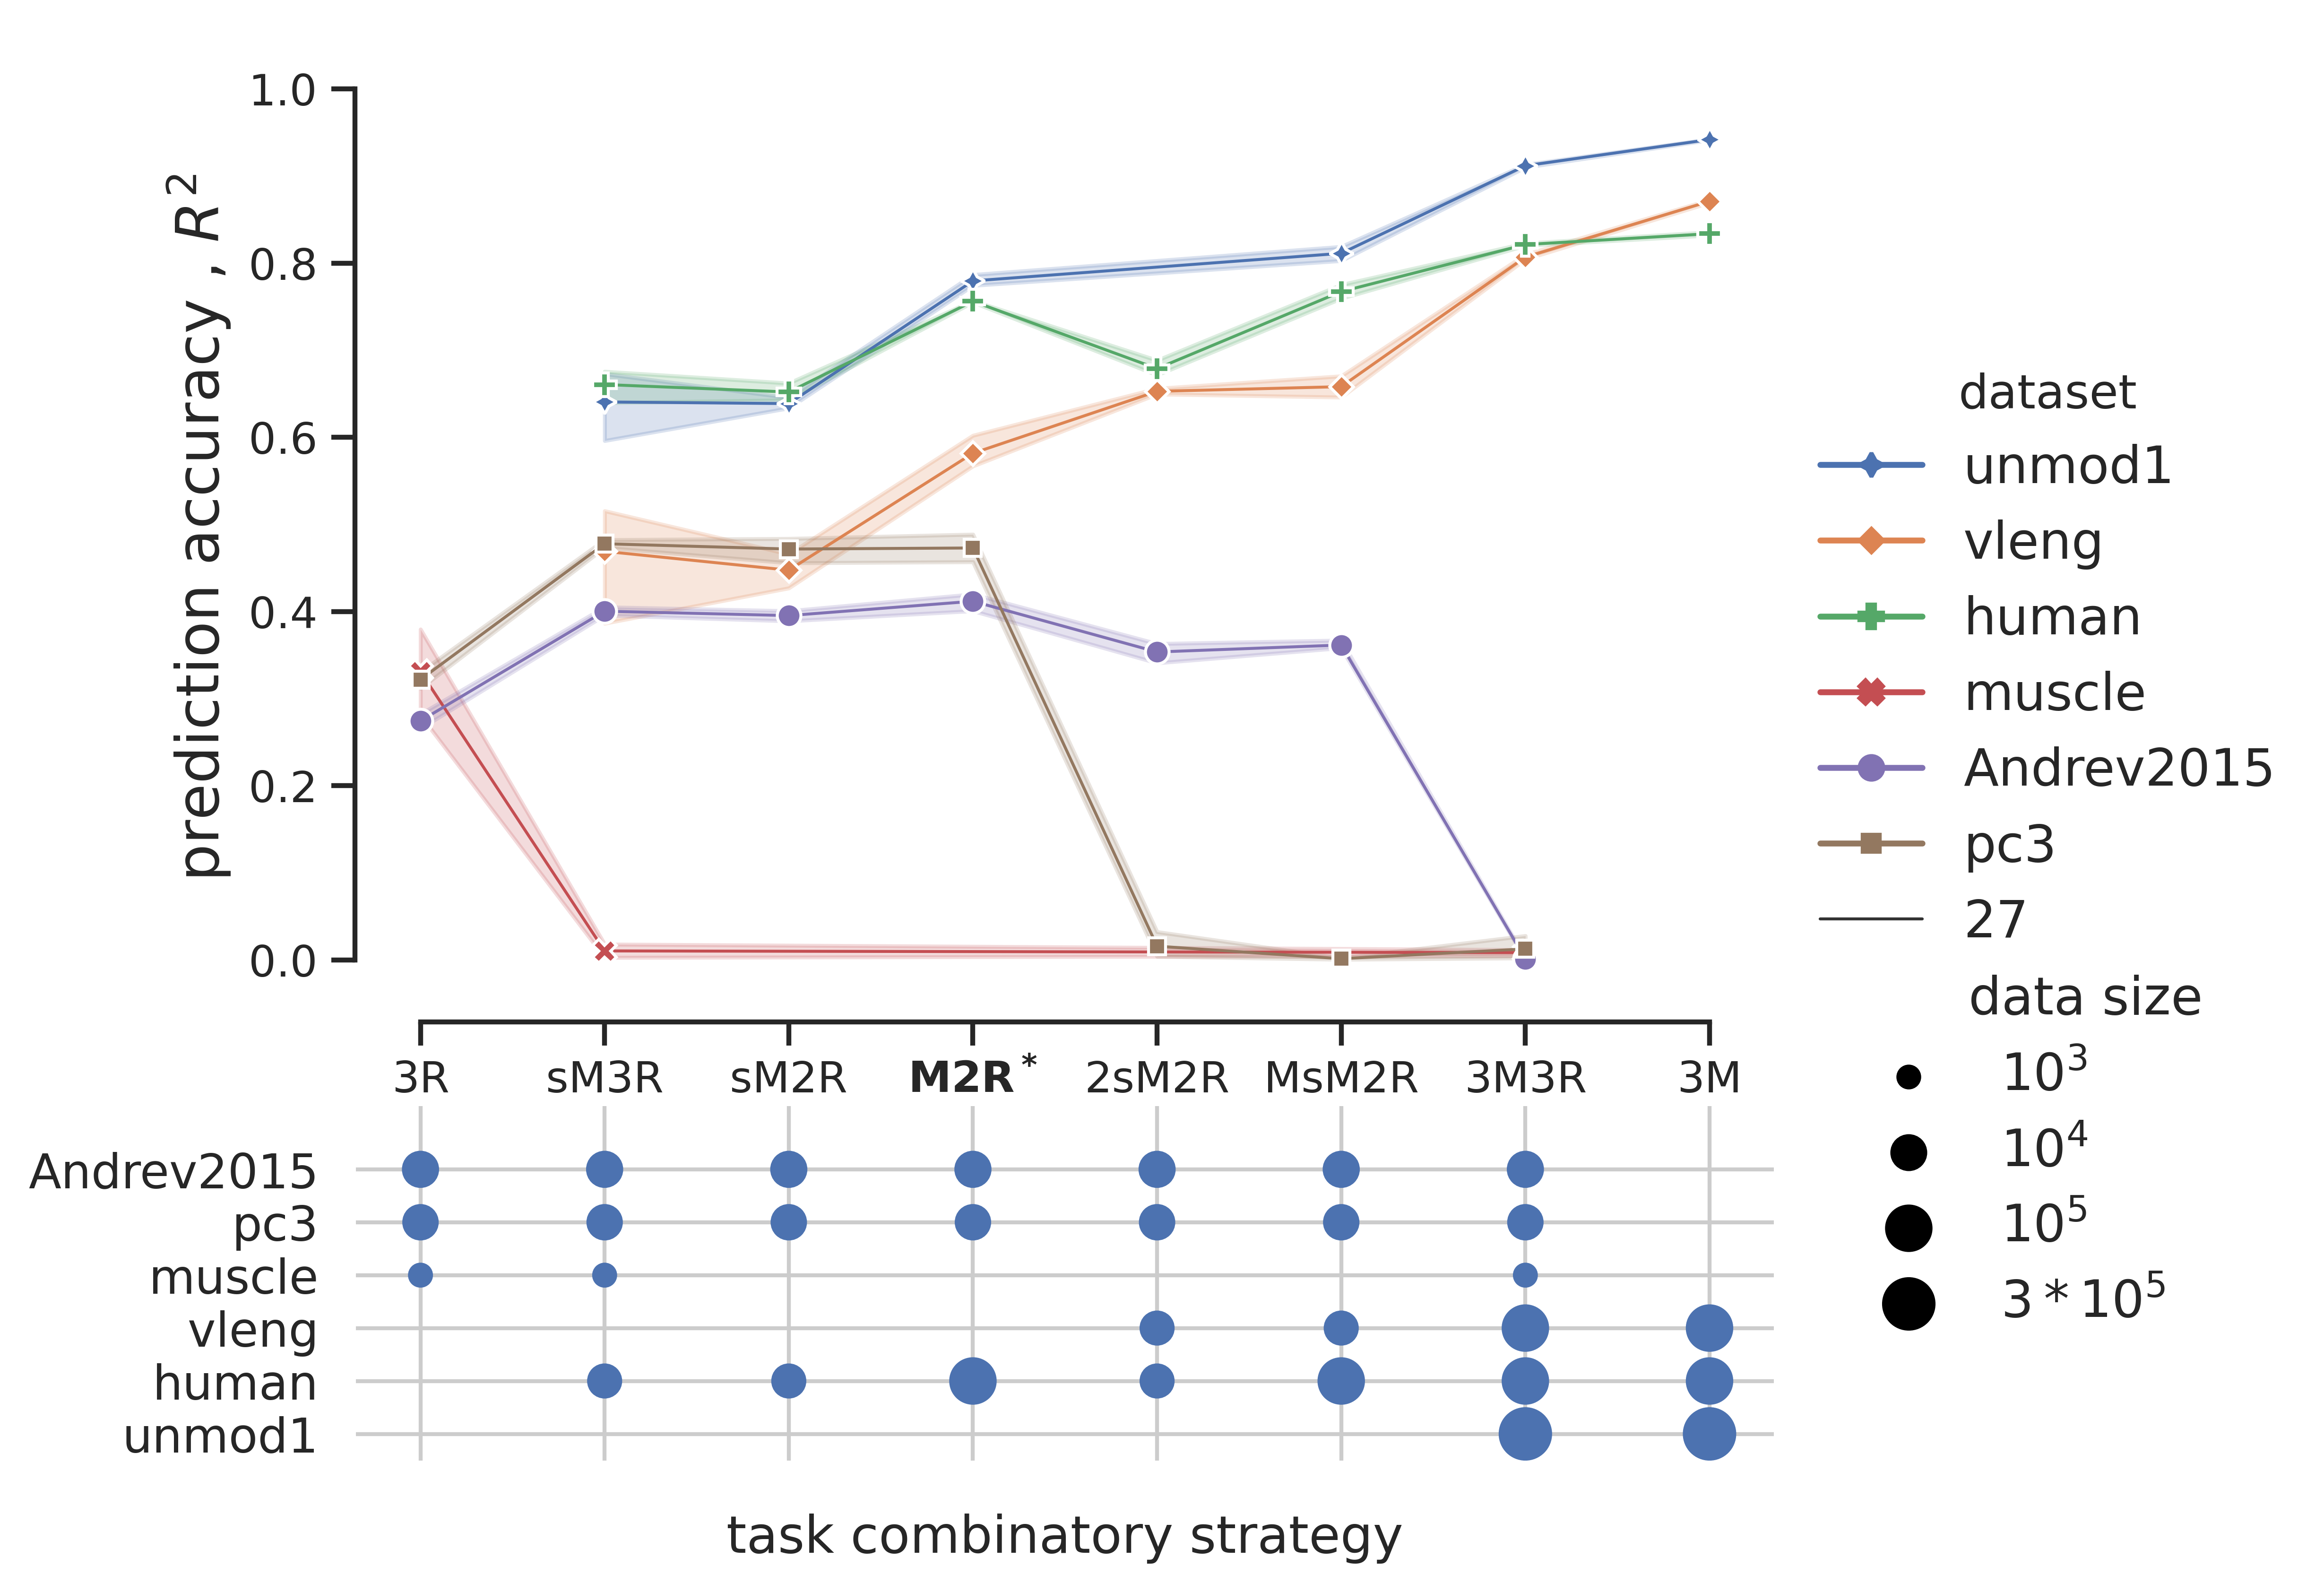

In [132]:
# line plot
sns.set_theme(style="ticks")
fig = plt.figure(figsize=(5,5), dpi=600)
ax1 = fig.add_axes([0, 0.31, 1, 0.7])
sns.lineplot(data= all_result , x='content_of_MAP', y ='R2', 
             hue='task' , style='task', hue_order= ['unmod1', 'vleng', 'human', 'muscle', 'Andrev2015', 'pc3'],
             ax=ax1  ,legend='full',markers=True, dashes=False, size=27);
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))


ax1.set_xticks(range(8))
ax1.set_xticklabels(['3R', 'sM3R', 'sM2R', r'$\bf{M2R}^*$', '2sM2R', 'MsM2R', '3M3R' ,'3M'], fontsize=10)
ax1.set_xlabel('')
ax1.set_ylim(-0.07, 1.07)

ax1.set_ylabel(r'prediction accuracy , $R^2$ ', fontsize=15)
sns.despine(left=False, bottom=False, ax=ax1, trim=True, offset=0.3)

ax1.legend(
       bbox_to_anchor = (1,0.7),
           frameon=False,
       ncol=1,
        title='dataset',
       fontsize=13)

patches.Rectangle([2.7, -0.02], 0.6, 1.04, ls='--', lw=3, alpha=0.3, fill=False,)


# the data usage

sns.set_theme(style="whitegrid",font_scale=1.1)
ax2 = fig.add_axes([0, 0.0, 1, 0.25])

coordinate = np.where(data_usage >= 0)
ax2.scatter(coordinate[0], coordinate[1] , s = np.log(data_usage.flatten('C') + 1)**3*0.08 )

gll = ax2.scatter([],[], s=28, marker='o', color='black')
gl = ax2.scatter([],[], s=70, marker='o', color='black')
gm = ax2.scatter([],[], s=122, marker='o', color='black')
ga = ax2.scatter([],[], s=158, marker='o', color='black')

ax2.legend((gll,gl,gm, ga),
       (r'$10^3$', r'$10^4$', r'$10^5$',r'$3*10^5$'),
       scatterpoints=1,
       bbox_to_anchor = (1,1.5),
           frameon=False,
       ncol=1,
        title='         data size',
       fontsize=13)

ax2.set_xlabel('task combinatory strategy', fontsize=13)
ax2.set_ylim(-0.5,6.2)
ax2.set_xticks(range(8))
ax2.set_xticklabels(['']*8)
ax2.set_yticks(range(6))
ax2.set_yticklabels(['unmod1', 'human', 'vleng', 'muscle', 'pc3', 'Andrev2015'])

sns.despine(left=True, bottom=True, ax=ax2)